Загрузка обработанных данных...
Загружено: (257673, 49)

	Предварительный анализ числовых признаков

Статистики числовых признаков:
                                      mean           std   min           max  \
remainder__dur                1.247000e+00  5.974000e+00   0.0  6.000000e+01   
remainder__spkts              1.977700e+01  1.359470e+02   1.0  1.064600e+04   
remainder__dpkts              1.851500e+01  1.119860e+02   0.0  1.101800e+04   
remainder__sbytes             8.572952e+03  1.737739e+05  24.0  1.435577e+07   
remainder__dbytes             1.438729e+04  1.461993e+05   0.0  1.465753e+07   
remainder__rate               9.125391e+04  1.603446e+05   0.0  1.000000e+06   
remainder__sload              7.060869e+07  1.857313e+08   0.0  5.988000e+09   
remainder__dload              6.582143e+05  2.412372e+06   0.0  2.242273e+07   
remainder__sloss              4.889000e+00  6.557500e+01   0.0  5.319000e+03   
remainder__dloss              6.744000e+00  5.370200e+01   0.0  5.50

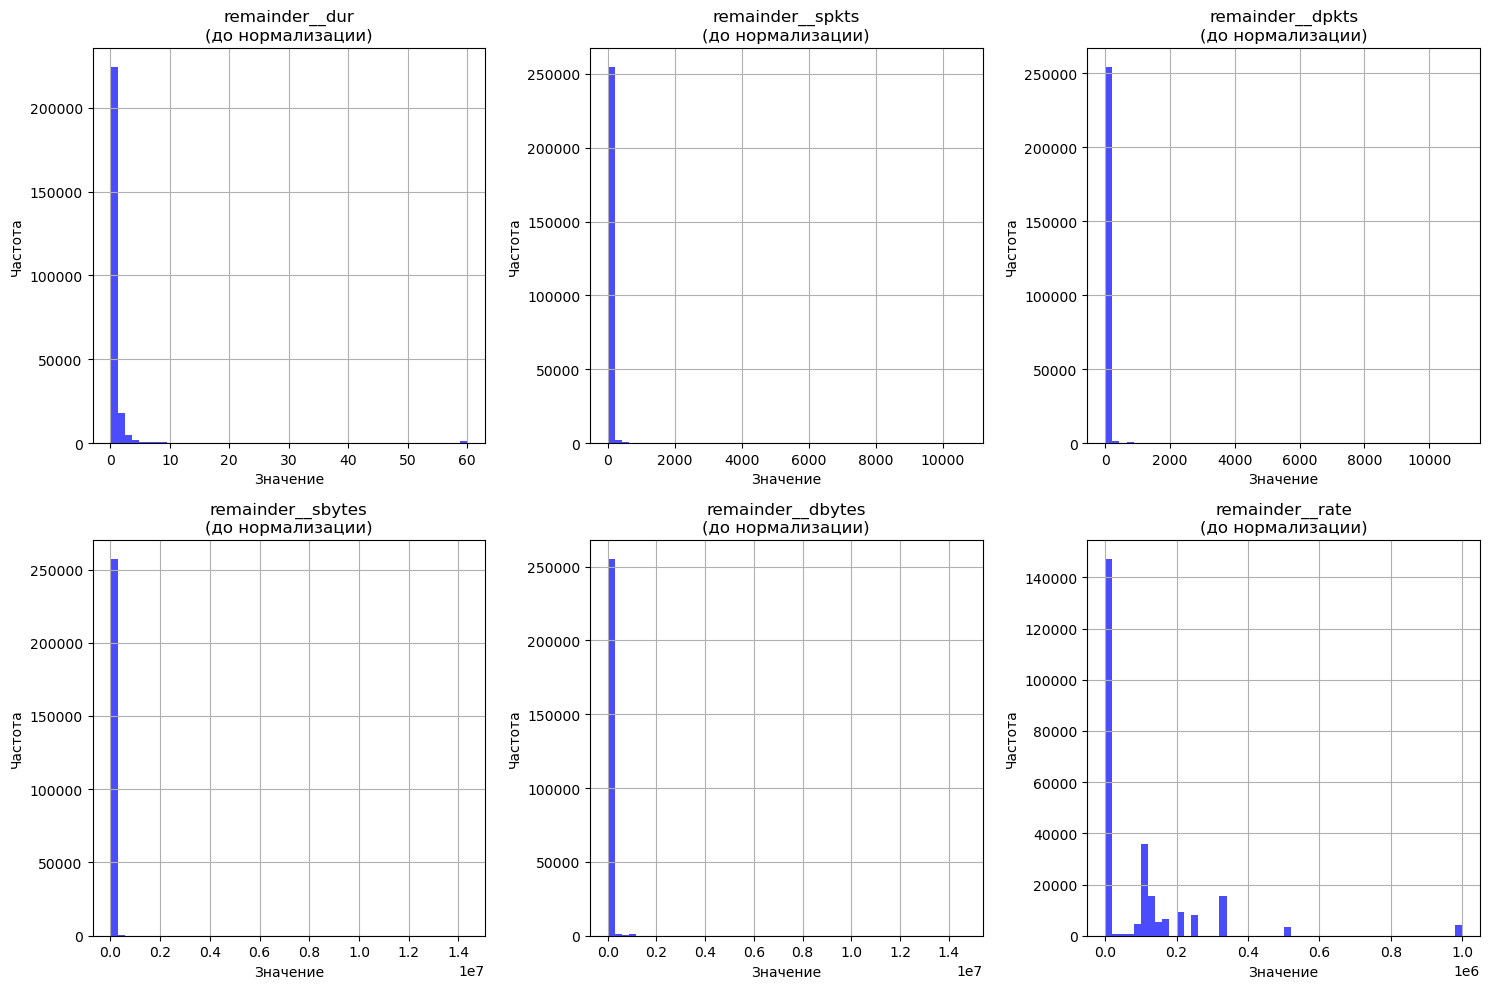

In [2]:
# Импорт библиотек
import sys
sys.path.append('..')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Загрузка обработанных данных
from src.features.normalization import NumericalNormalizer, analyze_numeric_features_before_normalization

print("Загрузка обработанных данных...")
X_processed = pd.read_parquet('../data/processed/X_processed.parquet')
y_binary = pd.read_parquet('../data/processed/y_binary.parquet')

print(f"Загружено: {X_processed.shape}")

# Анализ числовых признаков перед нормализацией
numeric_columns = [col for col in X_processed.columns if 'remainder__' in col]
stats = analyze_numeric_features_before_normalization(X_processed, numeric_columns)

# Визуализация распределений до нормализации
print("\nВизуализация распределений ДО нормализации:")
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, col in enumerate(numeric_columns[:6]):
    X_processed[col].hist(bins=50, ax=axes[i], alpha=0.7, color='blue')
    axes[i].set_title(f'{col}\n(до нормализации)')
    axes[i].set_xlabel('Значение')
    axes[i].set_ylabel('Частота')
reports_figures_path = Path("../reports/figures")
reports_figures_path.mkdir(parents=True, exist_ok=True)
plt.tight_layout()
plt.savefig('../reports/figures/before_normalization.png', dpi=300, bbox_inches='tight')
plt.show()

In [3]:
# Создаем и обучаем нормализатор
normalizer = NumericalNormalizer(method='standard')  # StandardScaler
X_normalized = normalizer.fit_transform(X_processed)

print(f"Данные после нормализации: {X_normalized.shape}")

# Проверяем результат нормализации
print("\nПроверка качества нормализации:")

# Проверяем статистики после нормализации
numeric_columns_normalized = [col for col in X_normalized.columns if 'num__' in col]
stats_after = X_normalized[numeric_columns_normalized].describe().T

print("\nСтатистики ПОСЛЕ нормализации (первые 5 признаков):")
print(stats_after[['mean', 'std', 'min', 'max']].head().round(3))

# Идеальные значения для StandardScaler: mean ≈ 0, std ≈ 1
perfect_normalization = (
    (abs(stats_after['mean']) < 0.01).all() and 
    (abs(stats_after['std'] - 1.0) < 0.1).all()
)

if perfect_normalization:
    print("Нормализация выполнена ИДЕАЛЬНО!!!")
else:
    print("Нормализация выполнена, но есть небольшие отклонения, возможно в развитии")

Обнаружено:
	- Числовых признаков для нормализации: 30
	- Бинарных признаков (пропущено): 19
	Нормализатор обучен (метод: standard)
	Нормализуется 30 числовых признаков
	Данные нормализованы: (257673, 49)
Данные после нормализации: (257673, 49)

Проверка качества нормализации:

Статистики ПОСЛЕ нормализации (первые 5 признаков):
                        mean  std    min      max
num__remainder__dur     -0.0  1.0 -0.209    9.834
num__remainder__spkts    0.0  1.0 -0.138   78.165
num__remainder__dpkts   -0.0  1.0 -0.165   98.222
num__remainder__sbytes  -0.0  1.0 -0.049   82.563
num__remainder__dbytes  -0.0  1.0 -0.098  100.159
Нормализация выполнена ИДЕАЛЬНО!!!


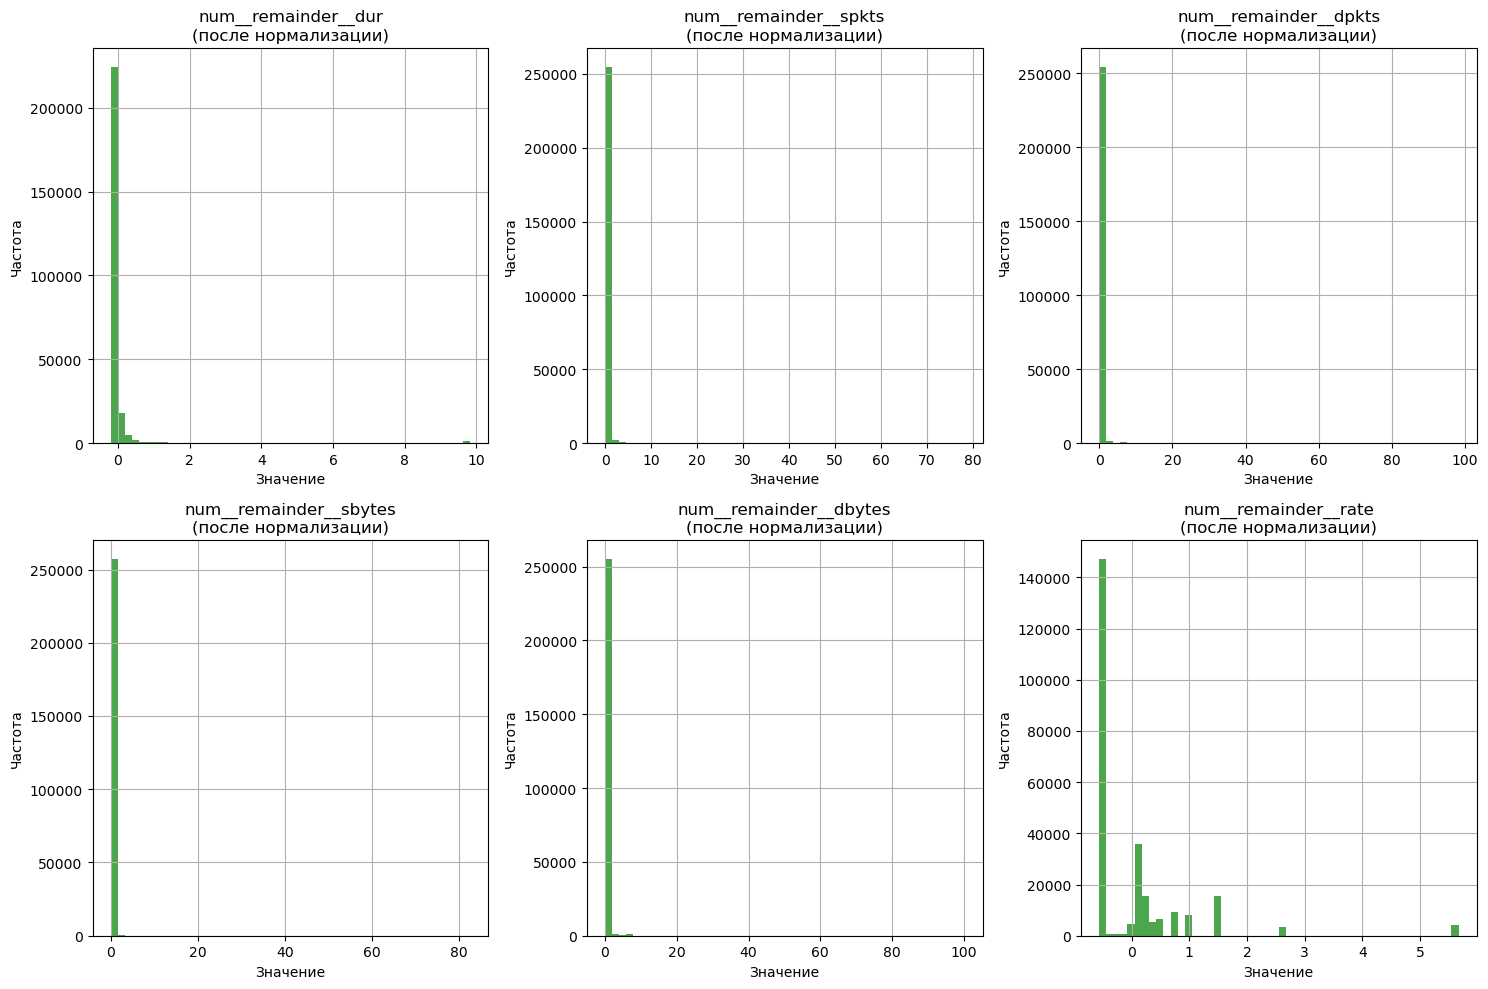


 Сравнение:


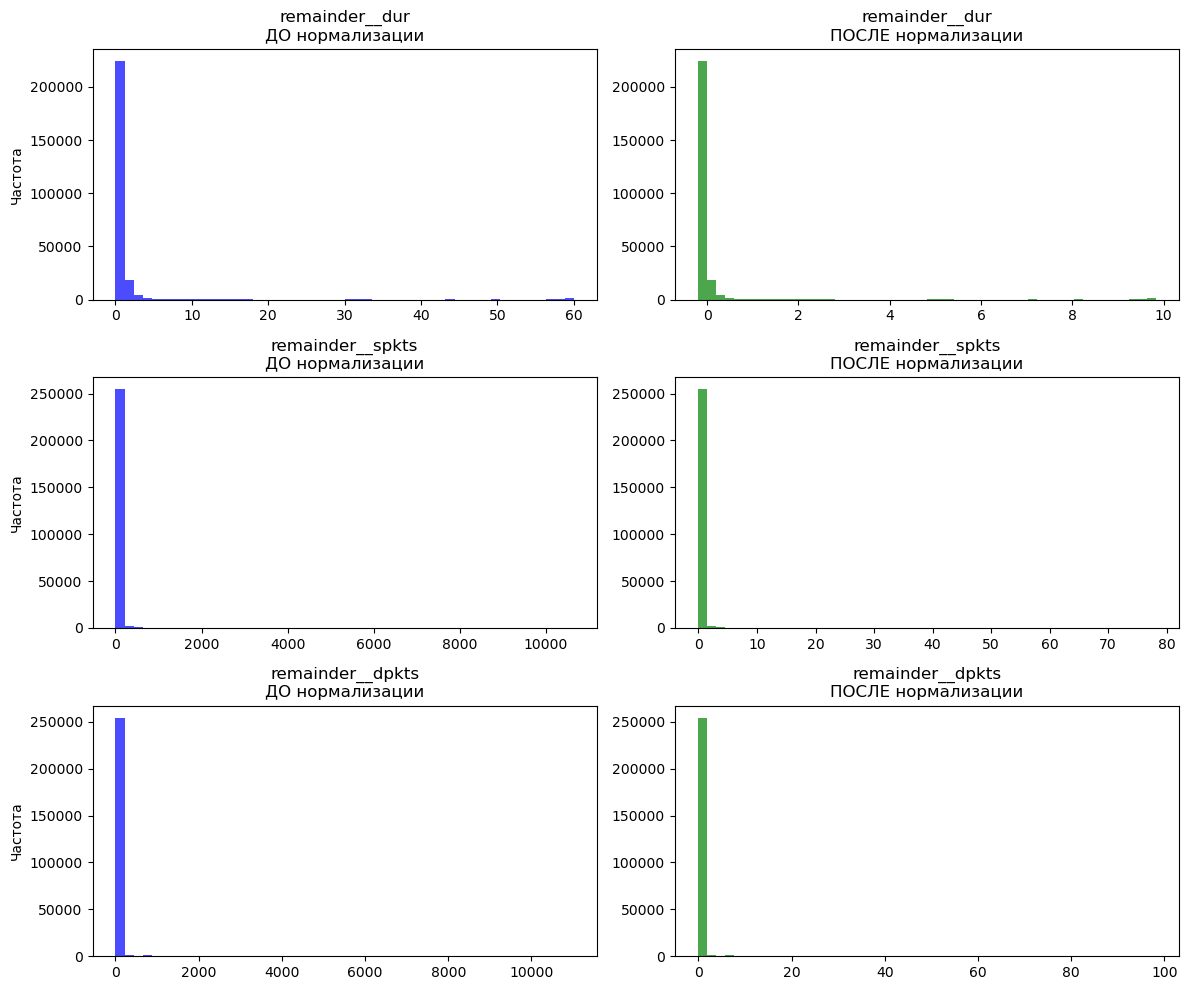

In [4]:
# Визуализация после нормализации
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, col in enumerate(numeric_columns_normalized[:6]):
    X_normalized[col].hist(bins=50, ax=axes[i], alpha=0.7, color='green')
    axes[i].set_title(f'{col}\n(после нормализации)')
    axes[i].set_xlabel('Значение')
    axes[i].set_ylabel('Частота')

plt.tight_layout()
plt.savefig('../reports/figures/after_normalization.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Сравнение:")
comparison_cols = numeric_columns[:3]  # первые 3 признака

fig, axes = plt.subplots(3, 2, figsize=(12, 10))

for i, col in enumerate(comparison_cols):
    # До нормализации
    axes[i, 0].hist(X_processed[col], bins=50, alpha=0.7, color='blue')
    axes[i, 0].set_title(f'{col}\nДО нормализации')
    axes[i, 0].set_ylabel('Частота')
    
    # После нормализации (находим соответствующую колонку)
    normalized_col = f"num__{col}"
    axes[i, 1].hist(X_normalized[normalized_col], bins=50, alpha=0.7, color='green')
    axes[i, 1].set_title(f'{col}\nПОСЛЕ нормализации')

plt.tight_layout()
plt.savefig('../reports/figures/normalization_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [5]:
# Сохраняем нормализованные данные
print("\nСохранение результатов:")

processed_path = Path("../data/processed")
models_path = Path("../models")

# Сохраняем нормализованные данные
X_normalized.to_parquet(processed_path / "X_normalized.parquet", index=False)
print(f"Нормализованные данные сохранены: data/processed/X_normalized.parquet")

# Сохраняем нормализатор
normalizer.save(models_path / "numerical_normalizer.joblib")
print(f"Нормализатор сохранен: models/numerical_normalizer.joblib")

# Создаем финальный отчет
report = f"""
ОТЧЕТ ПО НОРМАЛИЗАЦИИ ЧИСЛОВЫХ ПРИЗНАКОВ
{'='*50}

ПАРАМЕТРЫ НОРМАЛИЗАЦИИ:
- Метод: StandardScaler
- Нормализовано признаков: {len(numeric_columns_normalized)}
- Исходных признаков: {X_processed.shape[1]}
- После нормализации: {X_normalized.shape[1]}

РЕЗУЛЬТАТЫ НОРМАЛИЗАЦИИ:
- Средние значения: ~0
- Стандартные отклонения: ~1
- Качество: {'ИДЕАЛЬНО' if perfect_normalization else 'УДОВЛЕТВОРИТЕЛЬНО'}

СОХРАНЕННЫЕ ФАЙЛЫ:
1. data/processed/X_normalized.parquet - нормализованные данные
2. models/numerical_normalizer.joblib - обученный нормализатор
3. reports/figures/ - визуализации нормализации

ДАННЫЕ ГОТОВЫ ДЛЯ МОДЕЛИРОВАНИЯ!
"""

print(report)

# Сохраняем отчет
with open(processed_path / "normalization_report.txt", "w", encoding='utf-8') as f:
    f.write(report)

print("Отчет сохранен: data/processed/normalization_report.txt")


Сохранение результатов:
Нормализованные данные сохранены: data/processed/X_normalized.parquet
	Нормализатор сохранен в ..\models\numerical_normalizer.joblib
Нормализатор сохранен: models/numerical_normalizer.joblib

ОТЧЕТ ПО НОРМАЛИЗАЦИИ ЧИСЛОВЫХ ПРИЗНАКОВ

ПАРАМЕТРЫ НОРМАЛИЗАЦИИ:
- Метод: StandardScaler
- Нормализовано признаков: 30
- Исходных признаков: 49
- После нормализации: 49

РЕЗУЛЬТАТЫ НОРМАЛИЗАЦИИ:
- Средние значения: ~0
- Стандартные отклонения: ~1
- Качество: ИДЕАЛЬНО

СОХРАНЕННЫЕ ФАЙЛЫ:
1. data/processed/X_normalized.parquet - нормализованные данные
2. models/numerical_normalizer.joblib - обученный нормализатор
3. reports/figures/ - визуализации нормализации

ДАННЫЕ ГОТОВЫ ДЛЯ МОДЕЛИРОВАНИЯ!

Отчет сохранен: data/processed/normalization_report.txt
